#### Imports

In [24]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [25]:
!pip install -U evaluate accelerate imbalanced-learn scikit-learn==1.2.2 transformers einops

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
# import sys
# import torch

# sys.path.append('/kaggle/input/fake-news-utils')

# if torch.cuda.is_available():
#     print('CUDA available')
#     device = torch.device('cuda')
# else:
#     print('CUDA not available')
#     torch.device('cpu')

CUDA available


In [27]:
import pandas as pd
# from utils import *
from transformers import Trainer, EarlyStoppingCallback, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

label_type = 'binary_label'
multiclass = {
    'binary_label': 2,
    'trinary_label': 3,
    'default': 6, 
}

In [28]:
import evaluate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from datasets import load_dataset, Dataset
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, roc_curve

palette = sns.color_palette('hls')
truth_palette = sns.color_palette('hls', 15)[:6]

mappings = {
    'two-class': {
        'pants-on-fire': 1,
        'false': 1,
        'barely-true': 1,
        'half-true': 0,
        'mostly-true': 0,
        'true': 0
    },
    'three-class': {
        'pants-on-fire': 2,
        'false': 2,
        'barely-true': 1,
        'half-true': 1,
        'mostly-true': 0,
        'true': 0
    },
    'default': {
        'pants-on-fire': 5,
        'false': 0,
        'barely-true': 4,
        'half-true': 1,
        'mostly-true': 2,
        'true': 3
    }
}

mappings_inverse = {
    mappings['default'][k]: k for k in mappings['default']
}


# Function to map labels to binary or trinary labels (classes is a list)
# Default simply maps labels to label name (as used in LIAR dataset)
def map_labels(sample):
    label_name = mappings_inverse[sample['label']]
    sample['label_name'] = label_name
    sample['binary_label'] = mappings['two-class'][label_name]
    sample['trinary_label'] = mappings['three-class'][label_name]

    return sample

# Concatenate columns with [SEP] to add more information for classification
def concanenate_columns(dataset, max_len=100, splits=['train', 'test', 'validation'], cols=['statement', 'subject', 'speaker', 'context']):
    def truncate(sample, col, max_len):
        return {
            col: sample[col][:max_len] if len(sample[col]) > max_len else sample[col]
        }

    for split in splits:
        dataset[split] = dataset[split].map(lambda x: truncate(x, 'statement', max_len))
        columns = [dataset[split][col] for col in cols]
        concatenated_texts = [' [SEP] '.join(items) for items in zip(*columns)]
        dataset[split] = dataset[split].add_column('text', concatenated_texts)
    
    return dataset

# loads the dataset and applies the above functions and mappings
def load_data(path, split=None, remove_all=True, concat=False, max_len=75, label_type='label', cols=['statement', 'subject', 'speaker', 'context']):
    if split is not None:
        dataset = load_dataset(path, split=split)
        dataset = dataset.map(map_labels)
        return dataset
    
    dataset = load_dataset(path)

    dataset['train'] = dataset['train'].map(map_labels)
    dataset['test'] = dataset['test'].map(map_labels)
    dataset['validation'] = dataset['validation'].map(map_labels)

    if concat:
        dataset = concanenate_columns(dataset, max_len=max_len, cols=cols)

    if remove_all:
        cols_to_remove = dataset['train'].column_names
        cols_to_remove.remove(label_type)
        # cols_to_remove.remove('speaker')
        # cols_to_remove.remove('subject')
        # cols_to_remove.remove('context')
        # cols_to_remove.remove('statement')
        if concat:
            cols_to_remove.remove('text')
        dataset = dataset.remove_columns(cols_to_remove)
    
    if label_type != 'label':
        dataset = dataset.rename_column(label_type, 'label')

    return dataset

# balances dataset by minority class
def balance_dataset(dataset, split='train'):
    # Separate features and labels
    if 'text' not in dataset[split].column_names:
        X = np.array(dataset[split]['statement'])
    else:
        X = np.array(dataset[split]['text'])
    y = np.array(dataset[split]['label'])

    # Reshape the features
    X_reshaped = X.reshape(-1, 1)

    # Apply undersampling to balance the classes based on the minority class
    sampler = RandomUnderSampler(sampling_strategy='auto')
    X_resampled, y_resampled = sampler.fit_resample(X_reshaped, y)

    # Create a new balanced dataset
    balanced_dataset = Dataset.from_dict({
        'text': X_resampled.squeeze(1),
        'label': y_resampled
    })


    return balanced_dataset

def display_samples(dataset, num_samples=5):
    data = dataset.shuffle(seed=42).select(range(num_samples))

    for example in data:
        print(example['text'], example['label'])

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    print(labels)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

def evaluate_performance(trainer, inputs):
    from torch import from_numpy
    
    # basic evaluation of model
    trainer.evaluate(inputs)

    # get label probability prediction
    y_pred = trainer.predict(inputs)
    pred = from_numpy(y_pred.predictions)

    y_proba = softmax(pred)

    # get predicted labels and true labels
    y_true_labels = y_pred.label_ids
    y_pred_labels = np.argmax(y_proba, axis=1)

    for metric in [evaluate.load("f1"), evaluate.load("recall"), evaluate.load("precision")]:
        print(metric.compute(predictions=y_pred_labels, references=y_true_labels, average='macro'))

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    sns.heatmap(cm, annot=True)
    plt.show()

def get_roc_curve(model, inputs):
    y_pred = trainer.predict(inputs)
    y_proba = softmax(torch.tensor(y_pred.predictions))

    y_true_labels = y_pred.label_ids

    fpr, tpr, threshold = roc_curve(y_true_labels, y_proba[:, 1])

    return fpr, tpr, threshold


def plot_roc_curves(model, inputs, label='Train Classifier'):
    def plot_roc_curve(fpr, tpr, label=None, color='b'):
        plt.plot(fpr, tpr, label=label, color=color)

    fpr, tpr, threshold = get_roc_curve(model, inputs)

    plt.figure(figsize=(7, 5))
    plt.title(f'ROC Curve for {label}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axis([-.05, 1, 0, 1.05])


    palette = sns.color_palette('hls', 8)
    plot_roc_curve(fpr, tpr, label=label, color=sns.color_palette('hls')[0])

    plt.legend()
    plt.show()

def display_counts(dataset, split=None):
    if split:
        sns.countplot(data=pd.DataFrame(dataset[split]), x='label', palette=palette)
    else:
        sns.countplot(data=pd.DataFrame(dataset), x='label', palette=palette)
        
    plt.title('Label Count')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.show()

def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)


# def balance_dataset(dataset, split='train'):    
#     df = pd.DataFrame(dataset[split])
#     grouped_df = df.groupby('label')
#     min_class = grouped_df.size().min()
#     balanced_df = grouped_df.apply(lambda x: x.sample(n=min_class, replace=False)).reset_index(drop=True)
    
#     return Dataset.from_pandas(balanced_df)

#### Main Workflow

##### Load Data

In [29]:
data = load_dataset('liar')
df = pd.DataFrame(data['train'])

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
dataset = load_data(
    path='liar', 
    remove_all=True, 
    concat=True, 
    label_type=label_type, 
    cols=['statement', 'subject', 'speaker']
)

  0%|          | 0/3 [00:00<?, ?it/s]

##### Balance Data

In [31]:
trainset = balance_dataset(dataset, split='train')
testset = dataset['test']
valset = dataset['validation']

##### Explore Data

In [32]:
display_samples(testset, num_samples=3)

Says New START, passed while Clinton was secretary of state, is a treaty cu [SEP] candidates-biography,foreign-policy,nuclear [SEP] hillary-clinton 0
Says Ohio Rep. Marcy Kaptur actually lives in a fancy condo in the Washingt [SEP] congress,elections,job-accomplishments,message-machine-2012 [SEP] campaign-primary-accountability 1
"John McCain decided to stand with George Bush 95 percent of the time (last [SEP] bush-administration [SEP] barack-obama 0


In [33]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
def tokenize_dataset(data):
    return tokenizer(data['text'],
                     max_length=175,
                     truncation=True,
                     padding="max_length")

train_dataset = trainset.map(tokenize_dataset)
test_dataset = testset.map(tokenize_dataset)
val_dataset = valset.map(tokenize_dataset)

  0%|          | 0/8994 [00:00<?, ?ex/s]

In [34]:
# # model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=multiclass[label_type]).to(torch.device('cuda'))

# # Set up training arguments
# training_args = TrainingArguments(
#     output_dir="./sentiment_transfer_learning_transformer-binary/",
#     logging_dir='./sentiment_transfer_learning_transformer-binary/logs',
#     logging_strategy='epoch',
#     logging_steps=100,
#     num_train_epochs=5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     learning_rate=3e-4,
#     seed=42,
#     save_strategy='epoch',
#     save_steps=100,
#     evaluation_strategy='epoch',
#     eval_steps=100,
#     load_best_model_at_end=True
# )

# # Train the model
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
# )

# trainer.train()

# evaluate_performance(trainer, val_dataset)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_961/1431898176.py:33 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_961/1431898176.py'                          │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:1938 in _inner_training_loop     │
│                                                                                                  │
│   1935 │   │   │   │   │   self.control = self.callback_handler.on_step_begin(args, self.state,  │
│   1936 │   │   │   │                                                                             │
│   1937 │   │   │   │   with self.accelerator.accumulate(model):                                  │
│ ❱ 1938 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1939 │   │   │   │                                                                             │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:2759 in training_step            │
│                                                                                                  │
│   2756 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)                    │
│   2757 │   │                                                                                     │
│   2758 │   │   with self.compute_loss_context_manager():                                         │
│ ❱ 2759 │   │   │   loss = self.compute_loss(model, inputs)                                       │
│   2760 │   │                                                                                     │
│   2761 │   │   if self.args.n_gpu > 1:                                                           │
│   2762 │   │   │   loss = loss.mean()  # mean() to average on multi-gpu parallel training        │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/transformers/trainer.py:2784 in compute_loss             │
│                                                                                                  │
│   2781 │   │   │   labels = inputs.pop("labels")                                                 │
│   2782 │   │   else:                                                                             │
│   2783 │   │   │   labels = None                           

In [37]:
model = AutoModelForSequenceClassification.from_pretrained('/kaggle/input/trained-news-classifier')

eval_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_eval_batch_size=8,
    num_train_epochs=0,
)

trainer = Trainer(
    model=model,
    args=eval_args,
)

eval_results = trainer.evaluate(val_dataset)

print(eval_results)

{'eval_loss': 0.6566673517227173, 'eval_runtime': 4.0826, 'eval_samples_per_second': 314.509, 'eval_steps_per_second': 39.436}


/tmp/ipykernel_961/3799786908.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.6250104716557876}
{'recall': 0.624666016842647}
{'precision': 0.6255324820263961}


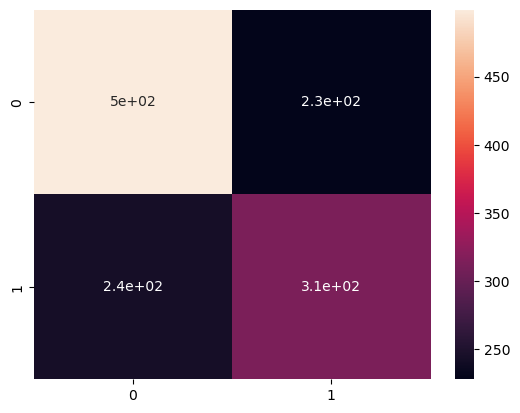

In [38]:
evaluate_performance(trainer, test_dataset)

/tmp/ipykernel_961/3799786908.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.631539653164009}
{'recall': 0.6314789252663504}
{'precision': 0.6316773270247379}


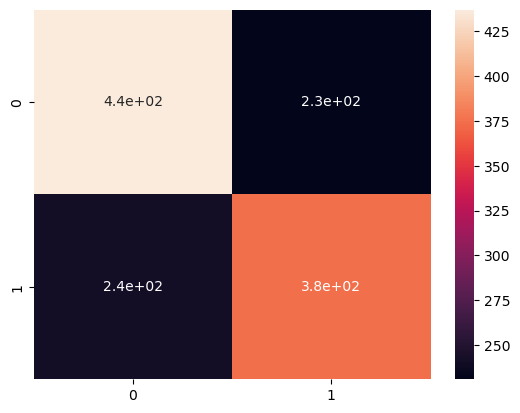

In [39]:
evaluate_performance(trainer, val_dataset)

/tmp/ipykernel_961/3799786908.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(torch.tensor(y_pred.predictions))


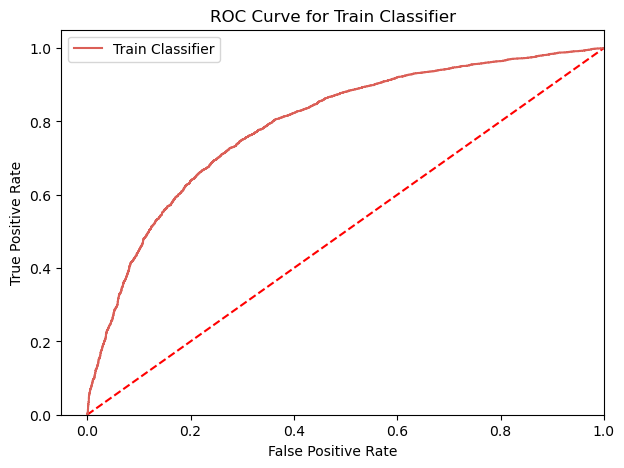

/tmp/ipykernel_961/3799786908.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(torch.tensor(y_pred.predictions))


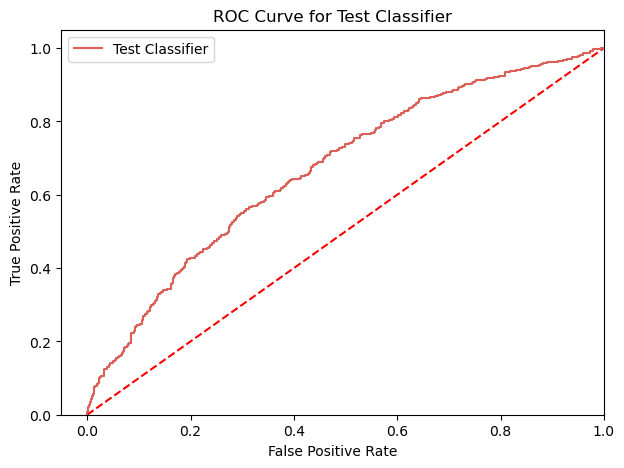

/tmp/ipykernel_961/3799786908.py:165: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(torch.tensor(y_pred.predictions))


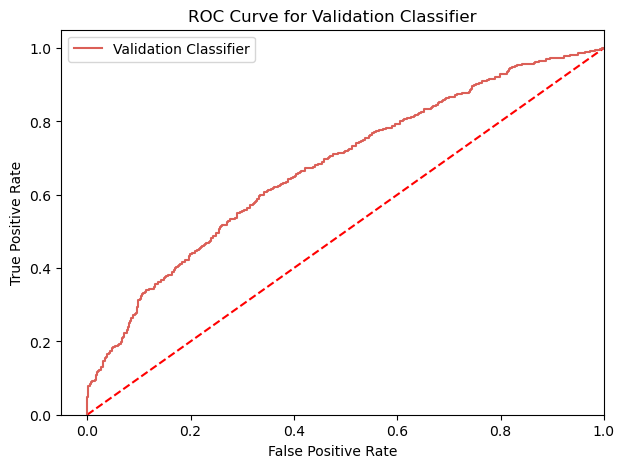

In [40]:
if label_type == 'binary_label':
    plot_roc_curves(model, train_dataset, label = 'Train Classifier')
    plot_roc_curves(model, test_dataset, label = 'Test Classifier')
    plot_roc_curves(model, val_dataset, label = 'Validation Classifier')

In [41]:
# trainer.save_model('trained_model')